In [120]:
import pandas as pd 
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


# 다중 선형 회귀

In [121]:
df = pd.read_csv("True.csv", encoding= 'cp949')
df.columns

Index(['시점', '시군산지', '일자', '품종', '도매가격.원.kg.', '거래량.톤.', '거래금액.백만원.',
       '마늘.면적..ha.', 'X10a당.생산량..kg.', '생산량..톤.', 'X10a당.생산량.톤', '평균',
       '평균기온..C.', '일강수량.mm.', '평균.풍속.m.s.', '합계.일조시간.hr.', '평균.지면온도..C.',
       '평균.5cm.지중온도..C.'],
      dtype='object')

## 산점도 행렬

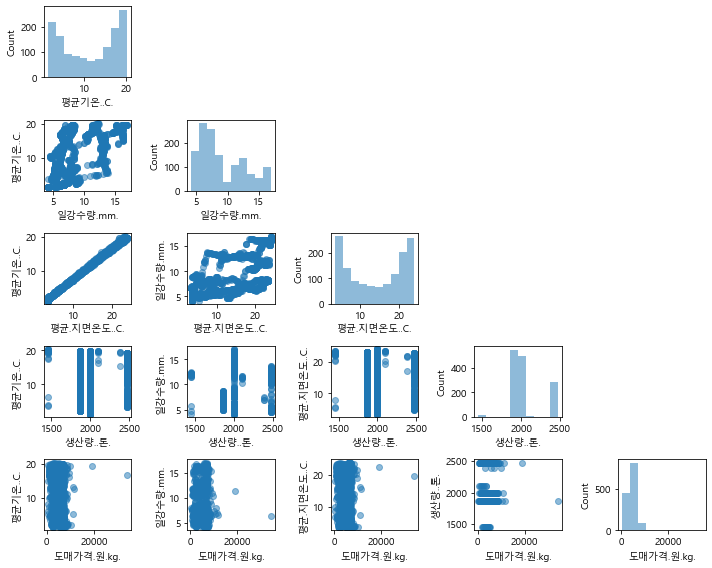

In [122]:
#-*-coding:utf-8=*-
cols = ['평균기온..C.', '일강수량.mm.', '평균.지면온도..C.', '생산량..톤.', '도매가격.원.kg.']

scatterplotmatrix(df[cols].values, figsize=(10, 8), 
                  names=cols, alpha=0.5)
plt.tight_layout()
# plt.savefig('images/10_03.png', dpi=300)
plt.show()

## 상관관계 행렬

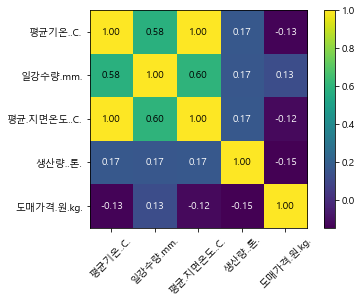

In [123]:
from mlxtend.plotting import heatmap


cm = np.corrcoef(df[cols].values.T)
hm = heatmap(cm, row_names=cols, column_names=cols)

# plt.savefig('images/10_04.png', dpi=300)
plt.show()

## 경사 하강법으로 회귀 모델의 파라미터 구하기

In [124]:
class LinearRegressionGD(object):
    
    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

### LinearRegressionGD를 실행해 보기 위해 데이터에서 평균기온 변수를 특성으로 사용하는 도매가격을 예측하는 모델을 훈련

In [125]:
X = df[['평균기온..C.']].values
y = df['도매가격.원.kg.'].values

In [126]:
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [127]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

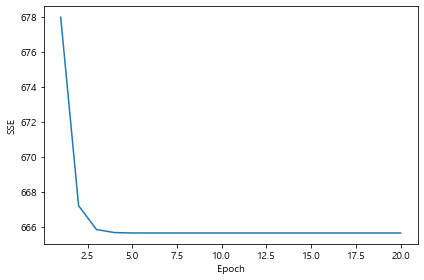

In [128]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

## 선형 회귀 모델이 데이터에 맞는지 확인

In [129]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return


### 큰 영향이 있다고 보기 힘듬

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


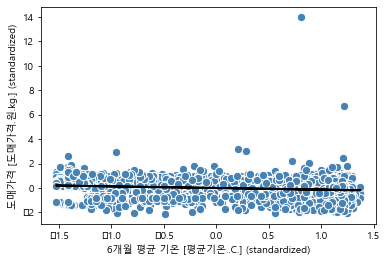

In [130]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('6개월 평균 기온 [평균기온..C.] (standardized)')
plt.ylabel('도매가격 [도매가격.원.kg.] (standardized)')

plt.show()

## 사이킷런으로 회귀 모델의 가중치 추정

In [131]:
from sklearn.linear_model import LinearRegression

In [132]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('기울기: %.3f' % slr.coef_[0])
print('절편: %.3f' % slr.intercept_)

기울기: -43.132
절편: 5385.978


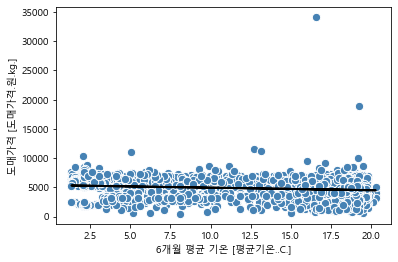

In [133]:
lin_regplot(X, y, slr)
plt.xlabel('6개월 평균 기온 [평균기온..C.]')
plt.ylabel('도매가격 [도매가격.원.kg.]')
# plt.savefig('images/10_07.png', dpi=300)
plt.show()

In [134]:
# 1로 채워진 열 벡터 추가
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print('기울기: %.3f' % w[1])
print('절편: %.3f' % w[0])

기울기: -43.132
절편: 5385.978


#### 
QR 분해는 실수 행렬을 직교 행렬(orthogonal matrix) $\boldsymbol{Q}$와 상삼각 행렬(upper triangular matrix) $\boldsymbol{R}$의 곱으로 표현하는 행렬 분해 방법입니다. 직교 행렬은 전치 행렬과 역행렬이 같습니다. 따라서 선형 회귀 공식을 $\boldsymbol{w}$에 정리하면 다음과 같이 쓸 수 있습니다.

$\boldsymbol{w} = \boldsymbol{X}^{-1}\boldsymbol{y} 
= (\boldsymbol{Q}\boldsymbol{R})^{-1}\boldsymbol{y}
= \boldsymbol{R}^{-1}\boldsymbol{Q}^{-1}\boldsymbol{y}
= \boldsymbol{R}^{-1}\boldsymbol{Q}^T\boldsymbol{y}
$

np.linalg.qr() 함수를 사용하여 QR 분해를 수행한 다음 np.linalg.inv() 함수를 사용해 상삼각 행렬의 역행렬을 구하여 계산할 수 있습니다.

In [135]:
Q, R = np.linalg.qr(Xb)
w = np.dot(np.linalg.inv(R), np.dot(Q.T, y))

print('기울기: %.3f' % w[1])
print('절편: %.3f' % w[0])

기울기: -43.132
절편: 5385.978


#### LinearRegression 클래스가 사용하는 scipy.linalg.lstsq 함수는 $\boldsymbol{X}$의 유사역행렬(pseudo-inverse matrix) $\boldsymbol{X}^+$을 구하여 다음처럼 바로 해를 구합니다.

$\boldsymbol{w} = \boldsymbol{X}^+\boldsymbol{y}$

유사역행렬은 특잇값 분해(SVD)로 얻은 $\boldsymbol{U}$, $\boldsymbol{\Sigma}$, $\boldsymbol{U}$로 계산합니다.

$\boldsymbol{X}^+ = \boldsymbol{V}\boldsymbol{\Sigma}^+\boldsymbol{U}^T$

여기에서 $\boldsymbol{\Sigma}^+$는 $\boldsymbol{\Sigma}$ 원소의 역수를 취하고 어떤 임곗값보다 작은 값은 0으로 만들어 얻을 수 있습니다. 예를 들어 $\boldsymbol{\Sigma}$의 행마다 가장 큰 값을 골라 $1 \times 10^{-15}$를 곱한 다음 이보다 작은 원소를 0으로 만듭니다. 넘파이 np.linalg.pinv() 함수를 사용하면 이런 작업을 모두 알아서 처리해 주므로 $\boldsymbol{X}^+$를 손쉽게 얻을 수 있습니다.

In [136]:
w = np.dot(np.linalg.pinv(Xb), y)

print('기울기: %.3f' % w[1])
print('절편: %.3f' % w[0])

기울기: -43.132
절편: 5385.978


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


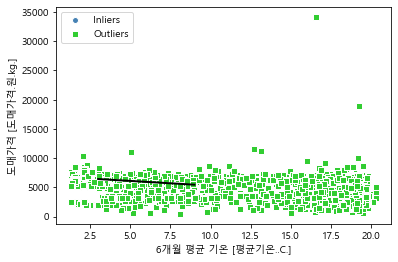

In [137]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_loss', 
                         residual_threshold=5.0, 
                         random_state=0)


ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('6개월 평균 기온 [평균기온..C.]')
plt.ylabel('도매가격 [도매가격.원.kg.]')
plt.legend(loc='upper left')

plt.show()

In [138]:
print('기울기: %.3f' % ransac.estimator_.coef_[0])
print('절편: %.3f' % ransac.estimator_.intercept_)

기울기: -160.876
절편: 6914.297


## 선형 회귀 모델의 성능 평가

In [139]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 5:].values
y = df['도매가격.원.kg.'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [140]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

In [141]:
import numpy as np
import scipy as sp

ary = np.array(range(100000))

In [142]:
%timeit np.linalg.norm(ary)

164 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [143]:
%timeit sp.linalg.norm(ary)


159 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [144]:
%timeit np.sqrt(np.sum(ary**2))


138 µs ± 8.33 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\textpath.py:74: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


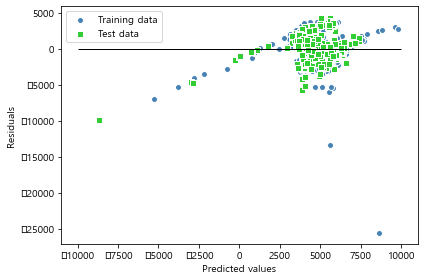

In [145]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10000, xmax=10000, color='black', lw=1)
plt.tight_layout()

# plt.savefig('images/10_09.png', dpi=300)
plt.show()

In [146]:
plt.tight_layout()

# plt.savefig('images/10_09.png', dpi=300)
plt.show()

<Figure size 432x288 with 0 Axes>

## 모델이 처참하네...

In [147]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

훈련 MSE: 3358403.718, 테스트 MSE: 2704732.210
훈련 R^2: 0.287, 테스트 R^2: 0.247


In [148]:

# 데이터 불러오기
df = pd.read_csv("True.csv", encoding= 'cp949')
df_data = df.drop(['도매가격.원.kg.'], axis=1)

# crim, rm, lstat을 통한 다중 선형회귀분석
x_data = df[["평균기온..C.","일강수량.mm.","평균.풍속.m.s.","합계.일조시간.hr.",'평균.지면온도..C.',"평균.5cm.지중온도..C."]] #변수 여러개
target = df[["도매가격.원.kg."]]

# for b0, 상수항 추가
x_data1 = sm.add_constant(x_data, has_constant = "add")

# OLS 검정
multi_model = sm.OLS(target, x_data1)
fitted_multi_model = multi_model.fit()
fitted_multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             도매가격.원.kg.   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     37.14
Date:                Sat, 21 Aug 2021   Prob (F-statistic):           7.69e-42
Time:                        01:45:16   Log-Likelihood:                -12188.
No. Observations:                1356   AIC:                         2.439e+04
Df Residuals:                    1349   BIC:                         2.443e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            7910.1344   1118.305      7.073      0.000    5716.329    1.01e+04
평균기온..C.        -1299.0502    240.535     -5.401      0.000   -1770.913    -827.187
일강수량.mm.           92.6416     24.637      3.760      0.000      44.310     140.973
평균.풍속.m.s.      -1516.4330    534.823     -2.835      0.005   -2565.608    -467.258
합계.일조시간.hr.      -338.3083    170.705     -1.982      0.048    -673.185      -3.432
평균.지면온도..C.      2131.2872    234.015      9.107      0.000    1672.215    2590.359
평균.5cm.지중온도..C. -1091.2108    258.566     -4.220      0.000   -1598.445    -583.977
==============================================================================
Omnibus:                     1065.424   Durbin-Watson:                   1.366
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           114174.484
Skew:                           2.925   Prob(JB):                         0.00
Kurtosis:                      47.571   Cond. No.                         623.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""